In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import plotnine as pn

import mtg
from importlib import reload
reload(mtg);

In [3]:
past_games = mtg.PastGames()

## Training a surrogate over the historical games.

/home/mson/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
/home/mson/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: l2_lambda
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[1]	training's binary_logloss: 0.691106	valid_1's binary_logloss: 0.691146
[2]	training's binary_logloss: 0.689147	valid_1's binary_logloss: 0.689327
[3]	training's binary_logloss: 0.687562	valid_1's binary_logloss: 0.687827
[4]	training's binary_logloss: 0.685996	valid_1's binary_logloss: 0.686383
[5]	training's binary_logloss: 0.684646	valid_1's binary_logloss: 0.685062
[6]	training's binary_logloss: 0.683297	valid_1's binary_logloss: 0.68383
[7]	training's binary_logloss: 0.682183	valid_1's binary_logloss: 0.682724
[8]	training's binary_logloss: 0.68077	valid_1's binary_logloss: 0.681431
[9]	training's binary_logloss: 0.679742	valid_1's binary_logloss: 0.680508
[10]	training's binary_logloss: 0.678825	valid_1's binary_logloss: 0.67963
[11]	training's binary_logloss: 0.677578	valid_1's binary_logloss: 0.678389
[12]

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

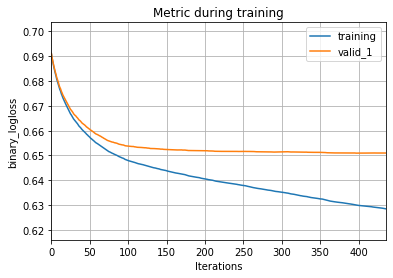

In [4]:
lgb_params = {'objective': 'binary', 'num_leaves': 32, 'l2_lambda': 0.3, 'max_depth': -1}

model = lgb.LGBMClassifier(**lgb_params, num_boost_round=1000)
trn, val = past_games.dsets.sets['trn'], past_games.dsets.sets['val']
model.fit(**past_games.dsets.sets['trn'], eval_set=[(trn['X'], trn['y']), (val['X'], val['y'])],
          early_stopping_rounds=30)
pos_idx = np.argmax(model.classes_)
lgb.plot_metric(model)

## Evaluating the surrogate.

In [5]:
y = past_games.dsets.sets['tst']['y']
pred = model.predict_proba(past_games.dsets.sets['tst']['X'])[:, pos_idx]
roc_auc_score(y_true=y, y_score=pred)

0.6552325994922179

##### Calibrated?

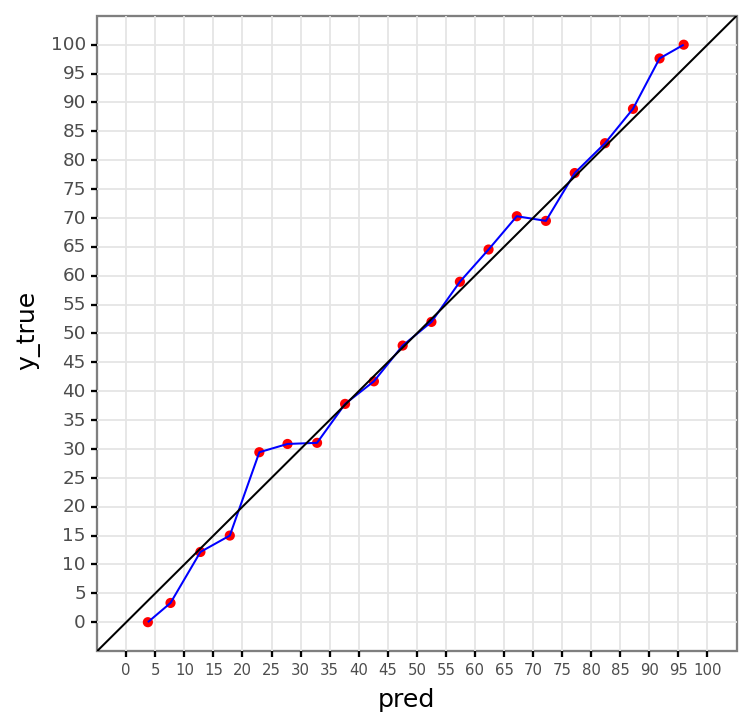

<ggplot: (8785835210171)>

In [6]:
pn.options.dpi = 165
mtg.CalibrationAnalyzer(y, pred).plot

### Seeing which of all possible decks the surrogate favors against the rival's.

In [7]:
rival_deck = mtg.RivalDeck(past_games).deck

In [8]:
possibles = mtg.PossibleDecks(past_games)
decks = possibles.get_decks()

In [9]:
deck_defeater = mtg.DeckDefeater(model, decks, rival_deck)
assert (deck_defeater.possible_games.columns == past_games.dsets.sets['trn']['X'].columns).all()
print(f"Mean win probability: {deck_defeater.mean_win_proba:.0%}\n\n")
print(f"Best deck:\n{deck_defeater.best_deck_str}")

Mean win probability: 41%


Best deck:
Alessin_Adamant_Angel_Deck_A_Count: 1
Bold_Battalion_Deck_A_Count: 0
Dreadwing_Darkfire_Dragon_Deck_A_Count: 0
Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count: 0
Gentle_Guard_Deck_A_Count: 0
Horrible_Hooligan_Deck_A_Count: 1
Kindly_Knight_Deck_A_Count: 0
Lilac_Lotus_Deck_A_Count: 0
Murderous_Minotaur_Deck_A_Count: 0
Patchy_Pirate_Deck_A_Count: 2
Sword_of_Shadows_Deck_A_Count: 8
Virtuous_Vigilante_Deck_A_Count: 0

win probability: 69%


In [10]:
deck_defeater.possible_decks_and_predictions

,Alessin_Adamant_Angel_Deck_A_Count,Bold_Battalion_Deck_A_Count,Dreadwing_Darkfire_Dragon_Deck_A_Count,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count,Gentle_Guard_Deck_A_Count,Horrible_Hooligan_Deck_A_Count,Kindly_Knight_Deck_A_Count,Lilac_Lotus_Deck_A_Count,Murderous_Minotaur_Deck_A_Count,Patchy_Pirate_Deck_A_Count,Sword_of_Shadows_Deck_A_Count,Virtuous_Vigilante_Deck_A_Count,p
0,1,0,0,0,0,1,0,0,0,2,8,0,0.692110
1,5,1,0,0,0,0,0,3,3,0,0,0,0.685053
2,5,2,0,0,0,0,0,3,2,0,0,0,0.685013
3,5,1,0,0,1,0,0,3,2,0,0,0,0.683616
4,5,0,0,2,0,0,0,3,2,0,0,0,0.681728
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352073,0,0,0,0,0,0,0,9,0,0,2,1,0.015074
1352074,0,0,0,0,0,0,0,10,0,0,2,0,0.014939
1352075,0,0,0,0,3,0,0,9,0,0,0,0,0.014288
1352076,0,0,0,0,0,0,0,9,0,0,3,0,0.013619


## Choosing decks for competitive play.
Strategies; we could choose the best... :
* whole-universe-generalist deck: the deck that performs best against all possible decks.
* actual-universe-generalist deck: the deck that performs best against all decks in the input data.
* whole-universe-counter deck: the deck that performs best against the whole-universe generalist deck.
* actual-universe-counter deck
* And so on, down the levels of recursion.
* Alternatively, the whole-universe-part-generalist-part-counter deck: 
a deck in-between  
the whole-universe-generalist deck 
and the whole-universe-counter deck.
* actual-universe-part-generalist-part-counter deck
* More?

#### Finding the whole-universe-generalist deck.

In [20]:
scorer = mtg.GameScorer(decks, model)

In [21]:

scored_chunks = scorer.score_chunks(2, 1)
scored_chunks

,game_id,p_avg
0,0_1_0_3_0_0_1_1_1_0_2_3,0.506432
1,1_1_1_4_1_0_1_1_2_0_0_0,0.559462


In [ ]:
# Need to chunk deck A too. Holy cow!
# Could we code up or use a gradient descent package 
# that helps us search deck-space?
# It would be implemented for every possible Deck A,
# to search a subspace of the possible deck B's.

##

# We don't need to look at all possible matches
# to search deck-A-space efficiently - since we're interested in average
# performance against all possible deck B's, we're only searching through
# variations on deck A.
# 
# That means we can use a further-from-points-I've-searched-so-far strategy to sample points from
# deck-A-space. Cuz deck A is small enough that we can embed it and find distances in it. 

## Analyzing the structure of deck-space.

## Analyzing the structure of matchups-space.